In [1]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../../data')

In [2]:
import numpy as np
import time
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

import pybnb
from transformers import *
from fbm import FBM
from pympler.classtracker import ClassTracker

from generalized_dtw import Warp
from brute_force_warped_pvar import *
from branch_and_bound_warped_pvar import BnBWarping

# Define paths and set problem parameters

In [10]:
n_points = 12

idx = np.linspace(0, 2*np.pi, n_points)
x = np.sin(idx)
y = np.cos(idx)

x = AddTime().fit_transform([x])[0]
y = AddTime().fit_transform([y])[0]

depth = 2
p = 1.35
norm = 'l1'

# Brute force algorithm

In [7]:
LP_seq = BruteForceWarpedPvar(x, y, p=p, depth=depth, norm=norm, augment=False, add_time=False, parallelise=False, 
                              optim_partition=True, pvar_advanced=False)

time to find all possible paths: 0.08


Loop over all warps: 100%|███████████████████████████████████████████████████████| 1682/1682 [00:00<00:00, 2872.92it/s]


total time for brute force with DP sequentially: 0.59 s


In [8]:
print('warped p-var: {:.2f}'.format(LP_seq.warped_pvar))
print('best warp: {}'.format(LP_seq.best_warp))
print('best partition: {}'.format(LP_seq.best_partition))

warped p-var: 6.00
best warp: [(0, 0), (1, 0), (2, 1), (3, 1), (3, 2), (4, 3), (4, 4), (5, 5), (5, 5), (5, 5), (5, 5)]
best partition: [0, 10]


# Branch and Bound algorithm

warped p-var: 6.20
wall time: 7.41 secs 

best_warp: [(0, 0), (1, 1), (2, 1), (3, 1), (4, 2), (5, 3), (6, 3), (7, 4), (8, 5), (8, 6), (9, 7), (10, 8), (11, 9), (11, 10), (11, 11)] 



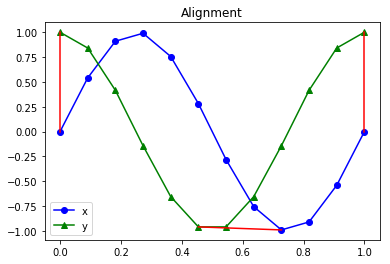

In [11]:
problem = BnBWarping(x=x, y=y, p=p, depth=depth, norm=norm, root_node=(0, 0), bc=3, cache_size=1024,
                     plot_2d=True, record_path=True, pvar_dist_mem=None, pvar_mem_org=None, 
                     initial_time=None, use_bound1=True, use_bound2=True, use_bound3=True)

solver = pybnb.Solver()

results = solver.solve(problem, log=None, queue_strategy='depth')
# results = solver.solve(problem, log=None, queue_strategy='breadth')
# results = solver.solve(problem, log=None, queue_strategy=('depth', 'random'))

print('warped p-var: {:.2f}'.format(results.objective))
print('wall time: {:.2f} secs \n'.format(results.wall_time))

best_warp = results.best_node.state
print('best_warp: {} \n'.format(best_warp[1:]))
_, optimal_partition = problem.distance(results.best_node.state, optim_partition=True)
problem.plot_alignment([best_warp[k] for k in optimal_partition])
plt.show()

# Visualize caching time evolution

In [12]:
df = pd.DataFrame.from_dict(problem.total_size_of_pvar_cache, orient='index')
df.columns = ['size of cache']

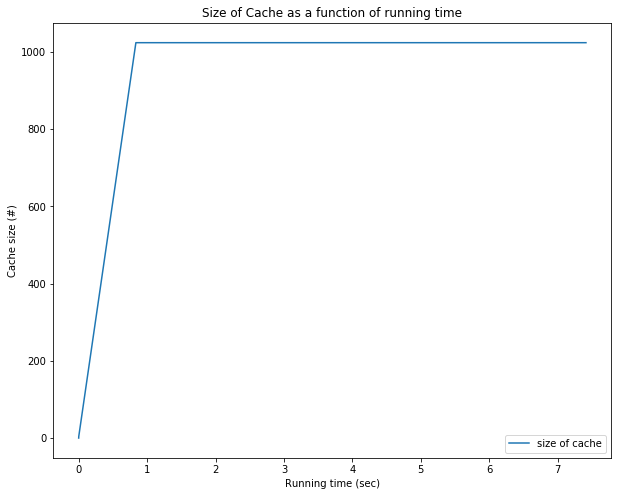

In [13]:
df.plot(figsize=(10, 8), title='Size of Cache as a function of running time')
plt.xlabel('Running time (sec)')
plt.ylabel('Cache size (#)')
plt.show()

# Time complexity and Memory consumption (as function of paths' length)

In [54]:
time_complexity = []
memory = []
lengths = np.arange(6, 15)

for N in lengths:

    idx = np.linspace(0, 3*np.pi, N)
    x = np.sin(idx)
    y = np.cos(idx)

    x = AddTime().fit_transform([x])[0]
    y = AddTime().fit_transform([y])[0]

    tracker = ClassTracker()
    problem = BnBWarping(x=x, y=y, p=p, depth=depth, norm=norm, root_node=(0, 0), bc=3, cache_size=1024,
                         plot_2d=True, record_path=True, pvar_dist_mem=None, pvar_mem_org=None, 
                         initial_time=None, use_bound1=True, use_bound2=True, use_bound3=True)
    tracker.track_object(problem)
    tracker.create_snapshot()
    results = pybnb.Solver().solve(problem, log=None, queue_strategy='depth')
    tracker.create_snapshot()
    
    memory.append(tracker.snapshots[1].tracked_total/1000)
    time_complexity.append(results.wall_time)

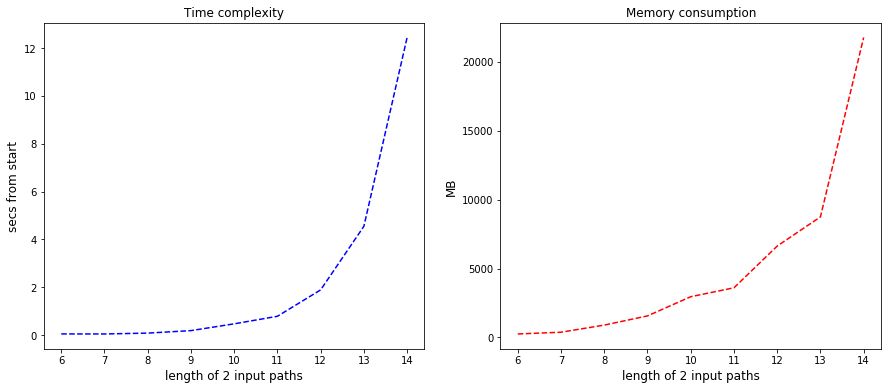

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(lengths, time_complexity, 'b--')
ax[1].plot(lengths, memory, 'r--')
ax[0].set_xlabel('length of 2 input paths', fontsize=12)
ax[1].set_xlabel('length of 2 input paths', fontsize=12)
ax[0].set_ylabel('secs from start', fontsize=12)
ax[1].set_ylabel('MB', fontsize=12)
ax[0].set_title('Time complexity', fontsize=12)
ax[1].set_title('Memory consumption', fontsize=12)
plt.show()

# Memory

In [ ]:
df = pd.DataFrame.from_dict(memory, orient='index')

In [ ]:
df.plot()
plt.show()

# Hyperparameter tuning (mainly p & boundary condition)

In [4]:
# hyper-parameters
pvars = [1., 1.05, 1.2, 1.5, 2., 3.]
boundary_conditions = [1, 2, 3, 4, 5]

# values to be stored
final_times = {}
final_nodes = {}
final_wpv = {}

# input paths specification
n_points = 12
x = np.sin(np.linspace(0, 2*np.pi, n_points+2))
y = np.cos(np.linspace(0, 3*np.pi, n_points))
x = AddTime().fit_transform([x])[0]
y = AddTime().fit_transform([y])[0]

# algo parameters
depth = 2
norm = 'l1'

for p in pvars:
    
    partial_times = {}
    partial_nodes = {}
    partial_wpv = {}
    
    for bc in boundary_conditions:
        
        # branch-and-bound
        problem = BnBWarping(x=x, y=y, p=p, depth=depth, norm=norm, root_node=(0, 0), bc=bc, 
                             plot_2d=False, pvar_advanced=False, pvar_dist_mem=None)
        results = pybnb.Solver().solve(problem, log=None, queue_strategy='depth')
        
        # inner-loop results
        partial_times[f'boundary_condition: {bc}'] = results.wall_time
        partial_nodes[f'boundary_condition: {bc}'] = results.nodes
        partial_wpv[f'boundary_condition: {bc}'] = results.objective
        
    # outer-loop results
    final_times[f'p: {p}'] = partial_times
    final_nodes[f'p: {p}'] = partial_nodes
    final_wpv[f'p: {p}'] = partial_wpv

In [5]:
df_times = pd.DataFrame.from_dict(final_times)
df_nodes = pd.DataFrame.from_dict(final_nodes)
df_wpv = pd.DataFrame.from_dict(final_wpv)

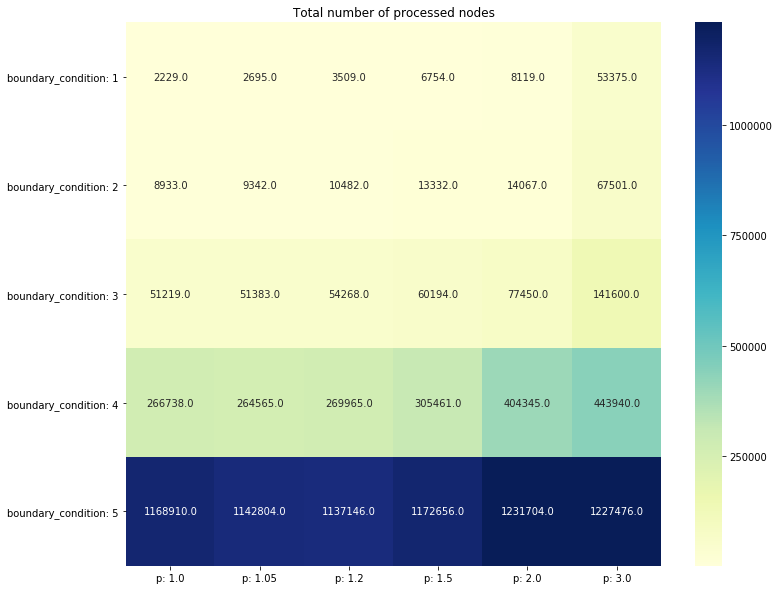

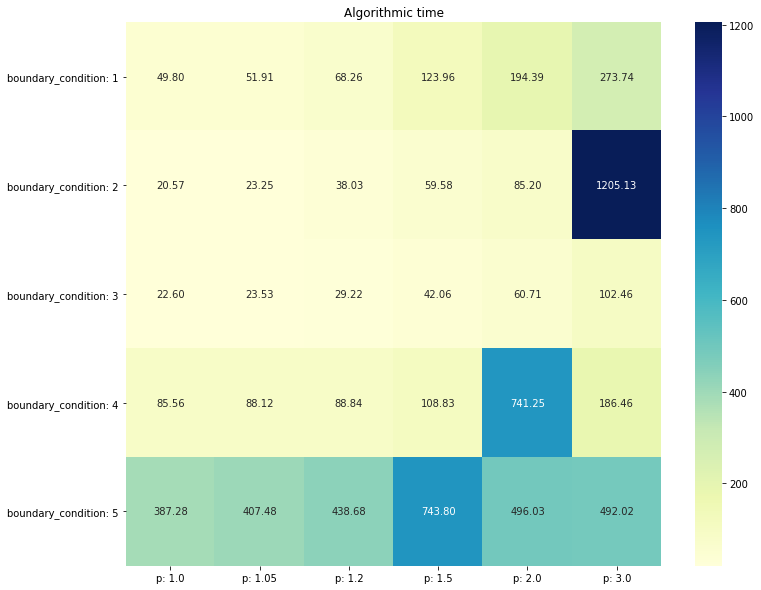

In [6]:
plt.figure(figsize=(12, 10))
seaborn.heatmap(df_nodes, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Total number of processed nodes')
plt.show()

plt.figure(figsize=(12, 10))
seaborn.heatmap(df_times, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title('Algorithmic time')
plt.show()